# ディープラーニングをやってみよう！

## shift+Enterでセル（枠で囲まれた部分）を実行できます。

### まず使うライブラリ達を読み込みます。

In [1]:
#numpyは多次元配列における数値計算を得意とするライブラリです。
import numpy as np
#matplotlibは可視化のためのライブラリです。
import matplotlib.pyplot as plt
%matplotlib inline

#kerasはdeep learning向けのフレームワークです。
#今回使うのはkerasというフレームワークでシンプルな記述が特徴です。
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD

#one-hot-encodingを使うためのライブラリを読み込む
from keras.utils import np_utils

#画像処理のための道具を読み込む
import cv2

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### ではさっそく使うデータを読み込みます。

In [2]:
#keras内のMNISTデータセットをimport します。
#kerasにはもともとMNISTデータが入っているため、自分でデータを集めるという行程を今回は省くことができます。
from keras.datasets import mnist

# MNISTデータをロードしてX_train, y_train, X_test, y_testに入れます。
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### 今回使うデータは「mnist」という有名な画像データ集です。
### 黒い背景に白い文字で数字が書かれている手書き数字画像で ↓こんな感じ

![MNIST](mnist1.png)

# データの前処理
## データの前処理をするにはまず、どんなデータを使っているかを調べる必要があります。

In [3]:
#.shapeでデータの形式を確認します。
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### ↑でわかるように、X_trainには28×28の画像が60000枚, y_trainにはX_trainの画像それぞれに対応するラベルが入っています。
### 同様にX_testには28×28の画像が10000枚, y_testにはX_testの画像それぞれに対応するラベルが入っています。

### 例えば

![MNIST](five.jpeg)

### がX_trainの1番目の画像だとしたら、y_trainの1番目は「５」というラベルです。

In [4]:
# データ型をdtypeで調べます。
print(X_train.dtype)
print(X_test.dtype)

uint8
uint8


### unit8は符号なし8ビット整数型を表しています。つまり、0 ～ 255までの整数で表現されています。

### 正規化（数値を0~1の範囲に収めること）すると精度が上がるので、正規化します。正規化するには、画素１つあたりに割り振られている数値の最大値（255）で数値を割れば良いのですが、255で割るとその値は整数ではなくなりuint8では表現しきれなくなります。
### よって↓これで、小数も表せるようにします。

In [5]:
#.astypeでデータ型を変形できます。「f」はfloat　不動小数点を表しています。
X_train = X_train.astype('f')
X_test = X_test.astype('f')

In [6]:
#データ型をdtypeで調べます。
print(X_train.dtype)
print(X_test.dtype)

float32
float32


### ちゃんと小数点も表せるようになってますね。

### 小数も表せるようになったので、正規化します。

In [7]:
# 画素を0.0-1.0の範囲に正規化
X_train /= 255
X_test /= 255

In [8]:
#例えばX_trainの１番目の画像の一行目の1列目に対応する画素は0.0という値を持つようになりました。
print(X_train[0][0][0])

0.0


In [9]:
#同様にラベルが入ってるデータ集のほうのデータ形式を確認します。
print(y_train.dtype)
print(y_test.dtype)

uint8
uint8


In [30]:
#データの形を確認します。
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


### 今、1と書かれた画像のラベルは1に、5と書かれた画像のラベルは5となっています。これだと、数字が書かれた画像を比較した時にそこには大小関係は存在しないのに、まるで大小関係が存在するかのようになってしまいます。よってこれをone hot encofingという方法を用いて直します。

![MNIST](one-hot.png)

In [13]:
#np_utils.to_categoricalでOne hot表現に変換できる
Y_train = np_utils.to_categorical(y_train, num_classes=10)
Y_test = np_utils.to_categorical(y_test, num_classes=10)

In [14]:
print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


### これで前処理は終了です。

## 次にデータを学習するモデルを構成します。（モデル組み方は様々なので、各自工夫してみてください。）

### ディープラーニングとはいえどやっていることは数式処理なので、値を関数に代入し新たな値を出すという作業を何度も何度も繰り返しています。

### keras（deep learning用のフレームワーク）ではaddで層を積み上げていくイメージでモデルを構成します。
### kerasには２つの利用可能なモデルがあるのですが、そのうちの１つのSequentialモデルを今回は利用します。

In [15]:
#まずSequentialでやるよ、modelの上に積み上げるよって教えてあげます。（正確にはインスタンスを作ったということ）
model = Sequential()  

# .addでmodel　に層を積み上げていきます。

# Flattenは下記参照
# input_shapeで入力する画像のサイズを指定。
model.add(Flatten(input_shape=(28, 28)))

# Denseで二層目の指定をしている。ここでは出力を800にしている。
model.add(Dense(800))

# Activation:で活性化関数を定義する。今回はrelu関数を使います。
model.add(Activation('relu'))

model.add(Dense(1500))
model.add(Activation('relu'))

model.add(Dense(300))
model.add(Activation('relu'))

# ↓10にしたのは今回分類したいクラスは0~9の10個だからです。
model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### flattenで以下のように画像行列をベクトルに変える。今回は28×28　→　784×1　にする。（学習につかう画像のサイズは28×28）


![flatten](flatten.png)

![MNIST](model.png)

### 次の層のノードの１つ１つがもつ値は前のノード達がもつ値を活性化関数(reluやsoftmax)に代入して出力された値です。

In [16]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(),metrics=['accuracy'])    

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### lossで誤差関数を、optimizerで最適化手法を、metricsで評価基準を指定しました。

## 以上でモデルの構成が終わりました。

## 作ったモデルとデータで学習します。

In [17]:
hist = model.fit(X_train,Y_train,epochs=2,validation_data=(X_test, Y_test),verbose=1,batch_size=100)


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 19s - loss: 0.9141 - acc: 0.7928 - val_loss: 0.3919 - val_acc: 0.9000
Epoch 2/2
60000/60000 [==============================] - 17s - loss: 0.3504 - acc: 0.9045 - val_loss: 0.2941 - val_acc: 0.9192


## 学習が終わりました。精度は9割を超えていますね。

### 因みにですが、データの前処理の段階で正規化をしましたが、もしも正規化をしていないと精度は↓こんな感じでした。

![MNIST](no_normalization.png)

### 精度が低いですね...





## では学習済みモデルを使って実際に予測してみましょう！！！

## 試してみたい画像をダウンロードして、このファイル（Deeplearning_text.ipynb）と同じ階層においてください。
## 画像はなるべく数字が中央にくるように、また形が正方形になるようにトリミングしてください。白背景で黒で太く数字が書かれているものを選んでください。

In [18]:
 #cv2.imreadで試してみたい画像をimgに代入する。
img = cv2.imread('three.jpeg')

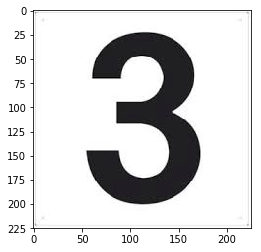

In [19]:
#試したい画像を一旦表示してみます。
plt.imshow(img)

In [20]:
#試したい画像の形を表示します。
print(img.shape)

(225, 225, 3)


### 上で（a,b,3）と表示されたなら、サイズがa×bでカラーであることを意味します、(a,b）と表示されたなら、サイズがa×bで白黒であることを意味します。

### 我々が作ったモデルはサイズが28×28で白黒の画像（背景が黒で文字が白い）で学習させたので試したい画像も同じようにしなければいけません。

In [21]:
#まずサイズを28×28にします
resized = cv2.resize(img, (28, 28))

In [22]:
#28×28となっていることを確認してください。
print(resized.shape)

(28, 28, 3)


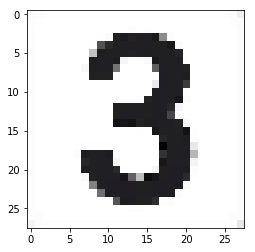

In [23]:
plt.imshow(resized)

In [24]:
#次に白黒にします。print(img.shape)で（a,b)となった人は不要です。
grayed = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)

In [25]:
#３番目の引数がなくなっていることを確認してください。
print(grayed.shape)

(28, 28)


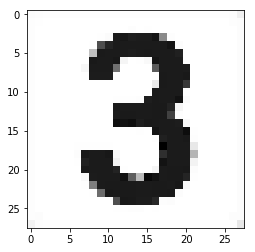

In [26]:
plt.gray()
plt.imshow(grayed)

In [27]:
#白と黒を入れ替えて、黒背景で白文字となるようにします。
inv = cv2.bitwise_not(grayed)

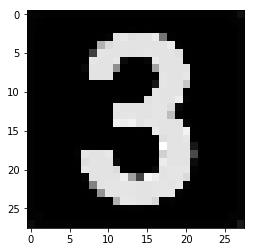

In [28]:
plt.gray()
plt.imshow(inv)

In [29]:
pred = model.predict(inv.reshape(1, 28, 28)).argmax()
print('この画像の数字はズバリ ', pred, 'でしょう！！')


この画像の数字はズバリ  3 でしょう！！
